In [4]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


from tqdm import tqdm
tf.config.list_physical_devices('GPU')

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.12.0
• Using TensorFlow Hub Version:  0.13.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Not Found. Running on CPU


## Image Flow

In [5]:
data_dir = 'Data'

datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1) # set validation split

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42) # set as training data

validation_generator = datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42) # set as validation data

num_classes = len(np.unique(train_generator.labels))

Found 25007 images belonging to 14 classes.
Found 2773 images belonging to 14 classes.


(32, 224, 224, 3)


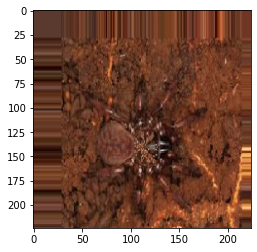

(32, 224, 224, 3)


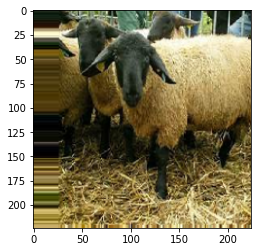

(32, 224, 224, 3)


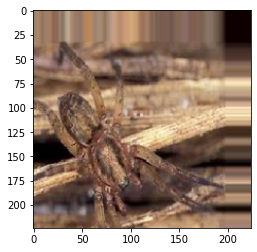

(32, 224, 224, 3)


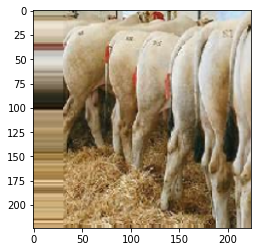

(32, 224, 224, 3)


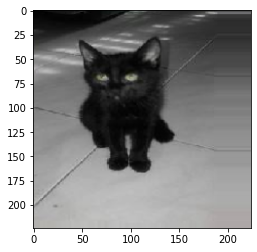

(32, 224, 224, 3)


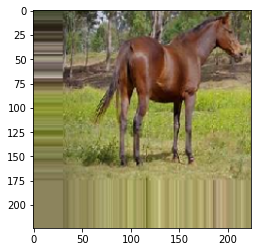

(32, 224, 224, 3)


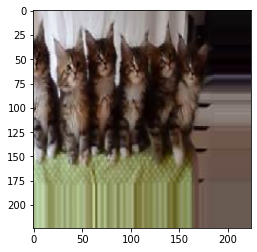

(32, 224, 224, 3)


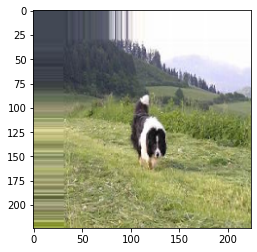

(32, 224, 224, 3)


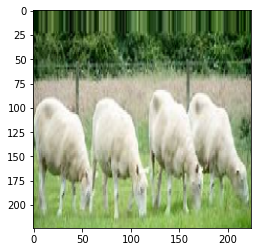

(32, 224, 224, 3)


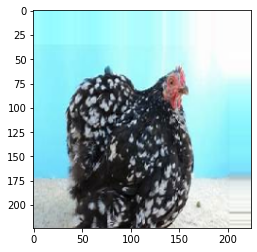

(32, 224, 224, 3)


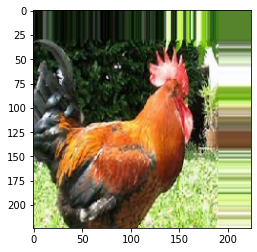

(32, 224, 224, 3)


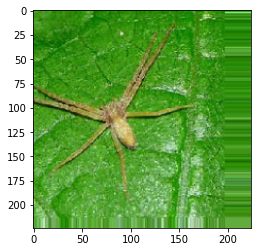

(32, 224, 224, 3)


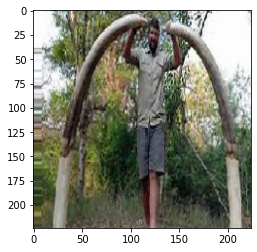

(32, 224, 224, 3)


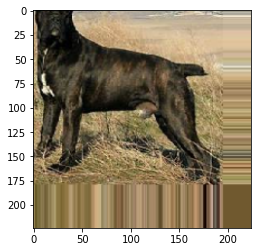

In [6]:
for _ in range(14):
    img, label = train_generator.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Model

### Select the Hub/TF2 Module to Use

In [7]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5"
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5 with input size (224, 224) and output dimension 1280


### Define Model

In [8]:
do_fine_tuning = True

In [9]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [10]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              2555993   
                                                                 
 dense (Dense)               (None, 14)                14028     
                                                                 
Total params: 2,570,021
Trainable params: 2,557,909
Non-trainable params: 12,112
_________________________________________________________________


In [11]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [12]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

hist = model.fit(train_generator,
                 validation_data=validation_generator,
                 epochs=10,
                 batch_size = 32,
                 callbacks = [es])

Epoch 1/10
782/782 [==============================] - 1739s 2s/step - loss: 0.8816 - accuracy: 0.8649 - val_loss: 0.6643 - val_accuracy: 0.9315
Epoch 2/10
782/782 [==============================] - 1519s 2s/step - loss: 0.6738 - accuracy: 0.9259 - val_loss: 0.6272 - val_accuracy: 0.9445
Epoch 3/10
782/782 [==============================] - 1799s 2s/step - loss: 0.6255 - accuracy: 0.9399 - val_loss: 0.6041 - val_accuracy: 0.9484
Epoch 4/10
782/782 [==============================] - 1707s 2s/step - loss: 0.5994 - accuracy: 0.9490 - val_loss: 0.6034 - val_accuracy: 0.9560
Epoch 5/10
782/782 [==============================] - 1675s 2s/step - loss: 0.5752 - accuracy: 0.9557 - val_loss: 0.6080 - val_accuracy: 0.9499
Epoch 6/10
782/782 [==============================] - 1621s 2s/step - loss: 0.5602 - accuracy: 0.9605 - val_loss: 0.6042 - val_accuracy: 0.9466
Epoch 7/10
782/782 [==============================] - 1530s 2s/step - loss: 0.5489 - accuracy: 0.9643 - val_loss: 0.6100 - val_accuracy:

## Export Model

In [13]:
ANIMALS_SAVED_MODEL = "model_14class_v2"

In [14]:
tf.saved_model.save(model, ANIMALS_SAVED_MODEL)

INFO:tensorflow:Assets written to: model_14class_v2\assets


INFO:tensorflow:Assets written to: model_14class_v2\assets


In [15]:
model.save("model_14class_v2.h5")

In [16]:
converter = tf.lite.TFLiteConverter.from_saved_model(ANIMALS_SAVED_MODEL)

In [18]:
!tensorflowjs_converter --input_format=keras {saved_model_path} 

'tensorflowjs_converter' is not recognized as an internal or external command,
operable program or batch file.
